In [42]:
#Load auth keys and make sure LLM is configured 
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

llm=ChatOpenAI(model="gpt-4.1-nano",temperature=0)
result=llm.invoke("Howdy")
result

AIMessage(content='Howdy! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CVUB8ElYY5QIyXkeYXV29QgikKf2S', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b8ccc523-99ce-49b9-ad4a-774bd93944db-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [24]:
# Load Data 

from langchain_community.document_loaders import WebBaseLoader
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]
docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [25]:
# Chunk,Split, Store and Retrieve
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

#View docs splits
print((doc_splits))

## Add alll these text to vectordb
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

retriever=vectorstore.as_retriever()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [26]:
#Router 
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

#Data Model
class RouteQuery(BaseModel):
    """ Route the user query to the most relevant datasource """
    datasource: Literal[
        "vectorstore","web_search"
    ]=Field(..., 
            description="Given a question from the user choose to route it to web search or a vectorstore."
            )

#Structure the output
structured_llm_router=llm.with_structured_output(RouteQuery)

In [27]:
#Prompt 
system="""
You are an expert at routing a user question to a vectorstore or web search.
The vetorstore contains documents related to agents, prompt engineering, and adversial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search.
"""
route_prompt= ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}")
    ]
)

question_router= route_prompt | structured_llm_router


In [45]:
#Test Routes to Web
print(
    question_router.invoke({"question":"Who will win FIFA 2026?"})
)

datasource='web_search'


In [46]:
#Test Routes to vector db
print(
    question_router.invoke({"question":"What is Agent Memory?"})
)

datasource='vectorstore'


In [47]:
# Retriever Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data Model
class GradeDocuments(BaseModel):
    """Relevance check for grading """
    binary_score: str=Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    ) 

structured_llm_grader=llm.with_structured_output(GradeDocuments)
#Prompt
system="""
You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keywords(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt=ChatPromptTemplate.from_messages(
[
    ("system",system),
    ("human","Retrieved document: \n\n {document} \n\n User question: {question}"),


]
)

retrieval_grader=grade_prompt|structured_llm_grader
question="agent memory"
docs=retriever.invoke(question)
doc_text=docs[1].page_content
print(retrieval_grader.invoke({"question":question,"document":doc_text}))


binary_score='yes'


In [48]:
#Generate 
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

#Prompt 
prompt= hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#chain 
rag_chain = prompt | llm | StrOutputParser()

#Run 
generation= rag_chain.invoke({"context":docs,"question":question})
print(generation)

Agent memory in LLM-powered autonomous systems includes short-term memory, which utilizes in-context learning to retain recent information, and long-term memory, which stores extensive data over time using external vector stores and retrieval mechanisms. This memory allows agents to behave based on past experiences, reflect on previous actions, and improve their performance. External databases and natural language streams are often used to record and access long-term experiences.


In [49]:
# Hallucination Check

class GradeHallucinations(BaseModel):
    """ Binary score for hallucination present in generated answer. """
    binary_score: str=Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    ) 

structured_llm_grader=llm.with_structured_output(GradeHallucinations)

#Prompt 
system="""
You are a grader assessing whether an LLM generation is grounded in/ supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is ground in/ supported by the set of facts.
"""

hallucination_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)
hallucination_grader= hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents":docs, "generation":generation})

GradeHallucinations(binary_score='yes')

In [50]:
# Answer Check

class GradeAnswer(BaseModel):
    """ Binary score for assessing answer addresses the question. """
    binary_score: str=Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    ) 

structured_llm_grader=llm.with_structured_output(GradeAnswer)

#Prompt 
system="""
You are a grader assessing whether an answer addresses/ resolves a question.
Give a binary score 'yes' or no. 'Yes' means that the answer resolves the question.
"""

answer_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","User question: \n\n {question} \n\n LLM generation: {generation}")
    ]
)
answer_grader= answer_prompt | structured_llm_grader
answer_grader.invoke({"question":question, "generation":generation})

GradeAnswer(binary_score='yes')

In [51]:
#Question Re-writer 

system="""
You are a question re-writer that converts an input question to a better version that is optimized for a web search.
Look at the input and try to reason about the underlying semantic intent /meaning.
"""
re_writer_prompt=ChatPromptTemplate.from_messages(
    [("system",system),
    (
        "human","Here is the initial question : \n\n {question} \n Formulate an improved question"
    )
    ]
)

question_rewriter=re_writer_prompt | llm| StrOutputParser()
optimized_question=question_rewriter.invoke({"question":question})
optimized_question

'What are effective strategies for managing and improving agent memory in customer service or AI systems?'

In [35]:
#web search
#Search 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool= TavilySearchResults(k=3)

In [36]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: Whether to add search
        documents: list of documents

    """

    question: str
    generation: str
    web_search: str
    documents:List[str]

In [ ]:
from langchain_core.documents import Document


def retrieve(state):
    """ 
    Retrieve  documents
    Args: 
        state (dict) : The current graph state

    Returns:
        state (dict): New Key added to state, documents, that contains retrieved documents
    """
    print("--- RETRIEVE ---")
    question =state["question"]

    #Retrival 
    documents= retriever.invoke(question)
    return {"documents":documents, "question":question}
def generate(state):
    """ 
    Generate answer 

     Args: 
        state (dict) : The current graph state

    Returns:
        state (dict): New Key added to state, documents, that contains LLM generation
    """

    print("--- GENERATE ---")
    question=state["question"]
    documents=state["documents"]

    #RAG generation
    generation= rag_chain.invoke({"context":documents,"question":question})
    return {"documents":documents, "question":question,"generation":generation}

def grade_documents(state):
    """ 
    Grade Document 

     Args: 
        state (dict) : The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("--- GRADE DOCUMENT RELEVANCE TO QUESTION---")
    question=state["question"]
    documents=state["documents"]

    #score each doc
    filtered_docs=[]
    for doc in documents:
        score=retrieval_grader.invoke({"question":question,"document":doc.page_content})
        grade=score.binary_score
        if grade=="yes":
            print("--- Grade : DOCUMENT RELEVANT ---")
            filtered_docs.append(doc)
        else:
            print("--- Grade : DOCUMENT NOT RELEVANT ---")
            continue
        return {"documents":filtered_docs,"question":question,"web_search":web_search}
    
def transform_query(state):
    """ 
    Transform the query to produce a better question 

     Args: 
        state (dict) : The current graph state

    Returns:
        state (dict): Updates the question key with a re-phrased question
    """

    print("--- TRANSFORM QUERY ---")
    question=state["question"]
    documents=state["documents"]

    #Rewrite question
    better_question=question_rewriter.invoke({"question":question})
    
    return {"documents":documents,"question":better_question}
def web_search(state):
    """ 
    Web search based on a re-phrased question 

     Args: 
        state (dict) : The current graph state

    Returns:
        state (dict): Updates the documents key with appended web results
    """

    print("--- WEB SEARCH ---")
    question=state["question"]

    #Web Search
    docs=web_search_tool.invoke({"query":question})
    web_results="\n".join(doc["content"] for doc in docs)
    web_results=Document(page_content=web_results)
    return {"documents":web_results,"question":question}

def route_question(state):
    """Route the question to web search or RAG
    
     Args: 
        state (dict) : The current graph state

    Returns:
        str: Binary decision for next node to be called 
    """
    print("--- ROUTE QUESTION ---")
    question=state["question"]
    source=question_router.invoke({"question":question})
    if source.datasource == "web_search":
        print("--- ROUTE QUESTION TO WEB SEARCH ---")
        return "web_search"
    elif source.datasource== "vectorstore":
        print("--- ROUTE QUESTION TO RAG ---")
        return "vectorstore"
        
def decide_to_generate(state):
    """
    Determines whether to generate an answer , or regenerate a question 

     Args: 
        state (dict) : The current graph state

    Returns:
        str: Binary decision for next node to be called
    """
    print("--- ASSES GRADED  DOCUMENTS ---")
    state["question"]
    web_search=state["web_search"]
    state["documents"]
    if web_search=="Yes":
        print("--- DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY ---")
        return "transform_query"
    else:
        print("--- DECISION: GENERATE ---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """ Determines whether the generation is grounded in the document and answers question.
     Args: 
        state (dict) : The current graph state

    Returns:
        str: Binary decision for next node to be called
    """
    print("--- CHECK HALLUCINATIONS ---")
    question=state["question"]
    documents=state["documents"]
    generation=state["generation"]

    score= hallucination_grader.invoke(
        {"documents":documents,"generation":generation}
    )
    grade=score.binary_score

    if grade == 'yes':
        print("--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---")
        print("--- GENERATION VS QUESTION ---")
        score=answer_grader.invoke({"question":question,"generation":generation})
        grade=score.binary_score
        if grade == "yes":
            print("--- DECISION: GENERATION ASSESSES QUESTION ---")
            return "useful"
        else :
            print("--- DECISION: GENERATION DOES NOT ASSESSES QUESTION")
            return "not useful"
    else:
        print("--- DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [38]:
from langgraph.graph import START,END,StateGraph

graph=StateGraph(GraphState)

#nodes
graph.add_node("web_search",web_search)
graph.add_node("retrieve",retrieve)
graph.add_node("grade_documents",grade_documents)
graph.add_node("generate",generate)
graph.add_node("transform_query",transform_query)

#build graph

graph.add_conditional_edges(
    START,
    route_question,{
        "web_search":"web_search",
        "vectorstore":"retrieve"
    }
)

#edges
graph.add_edge("web_search","generate")
graph.add_edge("retrieve","grade_documents")
graph.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate":"generate"
    }
)
graph.add_edge("transform_query","retrieve")
graph.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not_supported":"generate",
        "useful":END,
        "not_useful":"transform_query"
    }
)

graph=graph.compile()


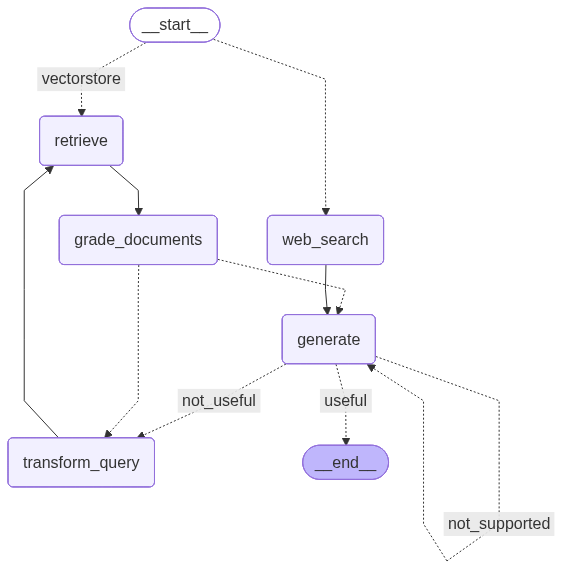

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [52]:
graph.invoke({"question":"What is machine Learning?","documents": []})

--- ROUTE QUESTION ---
--- ROUTE QUESTION TO WEB SEARCH ---
--- WEB SEARCH ---
--- GENERATE ---
--- CHECK HALLUCINATIONS ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---
--- GENERATION VS QUESTION ---
--- DECISION: GENERATION ASSESSES QUESTION


{'question': 'What is machine Learning?',
 'generation': 'Machine learning is a subset of artificial intelligence that enables computers to learn from data and improve their performance over time without being explicitly programmed. It involves developing algorithms that can identify patterns, make predictions, and classify data. Machine learning is widely used in various applications, such as image recognition, data analysis, and predictive modeling.',
 'documents': Document(metadata={}, page_content='What is machine learning?\n\nMachine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems. [...] When companies today deploy artificial intelligence programs, they are most likely using machine learning —so much so that the terms are often used interchangeably, and sometimes amb

In [55]:
graph.invoke({"question":"Agent","documents": []})

--- ROUTE QUESTION ---
--- ROUTE QUESTION TO RAG ---
--- RETRIEVE ---
--- GRADE DOCUMENT RELEVANCE TO QUESTION---
--- Grade : DOCUMENT NOT RELEVANT ---
--- Grade : DOCUMENT RELEVANT ---
--- ASSES GRADED  DOCUMENTS ---
--- DECISION: GENERATE ---
--- GENERATE ---
--- CHECK HALLUCINATIONS ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---
--- GENERATION VS QUESTION ---
--- DECISION: GENERATION ASSESSES QUESTION


{'question': 'Agent',
 'generation': 'An agent, in this context, is an autonomous system powered by a large language model (LLM) that functions as its core controller. It uses components like planning, memory, and tool use to break down tasks, reflect, learn from past actions, and access external information. This setup enables the agent to handle complex tasks efficiently and adaptively.',
 'web_search': <function __main__.web_search(state)>,
 'documents': [Document(id='9997e028-fced-4d23-8b11-7aaa978f1f16', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general proble